PID Controller Notebook
* Ziegler-Nichols Method

Tutor:
* Anthropic's AI Claude  

## The Ziegler-Nichols Method for tuning PID controllers.

This method is widely used in control systems engineering to determine appropriate PID controller parameters.

Here's an overview of the Ziegler-Nichols Method:

1. The Ziegler-Nichols Method is an empirical technique for tuning PID (Proportional-Integral-Derivative) controllers.

2. It was developed by John G. Ziegler and Nathaniel B. Nichols in 1942.

3. The method aims to achieve good control performance by setting appropriate values for the PID controller's three parameters: Kp (proportional gain), Ti (integral time), and Td (derivative time).

4. There are two main variants of the Ziegler-Nichols Method:
   a) The step response method (also known as the open-loop method)
   b) The ultimate sensitivity method (also known as the closed-loop method)

5. For this overview, we'll focus on the ultimate sensitivity method, as it's more commonly used.

6. The procedure for the ultimate sensitivity method is as follows:
   a) Set Ti to infinity and Td to zero, leaving only the proportional control active.
   b) Increase Kp until the system oscillates with constant amplitude (at the ultimate gain Ku).
   c) Record the ultimate gain (Ku) and the oscillation period (Tu).
   d) Set the PID parameters according to the Ziegler-Nichols tuning table.

Here are the key equations for a PID controller:

1. PID control equation:
   u(t) = Kp * e(t) + Ki * ∫e(t)dt + Kd * de(t)/dt

2. Relationships between parameters:
   Ki = Kp / Ti
   Kd = Kp * Td

A table glossary of terms and symbols:





| Term/Symbol | Description |
|-------------|-------------|
| PID | Proportional-Integral-Derivative |
| Kp | Proportional gain |
| Ti | Integral time |
| Td | Derivative time |
| Ki | Integral gain (Ki = Kp / Ti) |
| Kd | Derivative gain (Kd = Kp * Td) |
| Ku | Ultimate gain (gain at which system oscillates with constant amplitude) |
| Tu | Ultimate period (oscillation period at ultimate gain) |
| e(t) | Error signal (difference between setpoint and measured process variable) |
| u(t) | Control signal (output of the PID controller) |


The Ziegler-Nichols tuning table for setting PID parameters based on the ultimate sensitivity method:





| Controller Type | Kp | Ti | Td |
|-----------------|----|----|----|
| P | 0.5 * Ku | - | - |
| PI | 0.45 * Ku | Tu / 1.2 | - |
| PID | 0.6 * Ku | Tu / 2 | Tu / 8 |


This overview covers the key aspects of the Ziegler-Nichols Method for tuning PID controllers. The method provides a systematic approach to determining controller parameters, although it's worth noting that it often results in aggressive tuning and may require fine-tuning for optimal performance in specific applications.

Finding ultimate gain and period...
Iteration 1/200, Kp = 0.1000
Ultimate gain (Ku): 0.1000
Ultimate period (Tu): 1.3701
Initial PID parameters: Kp = 0.0600, Ki = 0.0876, Kd = 0.0103
Do you want to manually fine-tune the PID parameters? (y/n): n
Final PID parameters: Kp = 0.0600, Ki = 0.0876, Kd = 0.0103

Performance Metrics:
Steady State Value: 0.5227
Steady State Error: 0.4773
Rise Time: None
Settling Time: None
Overshoot (%): 0


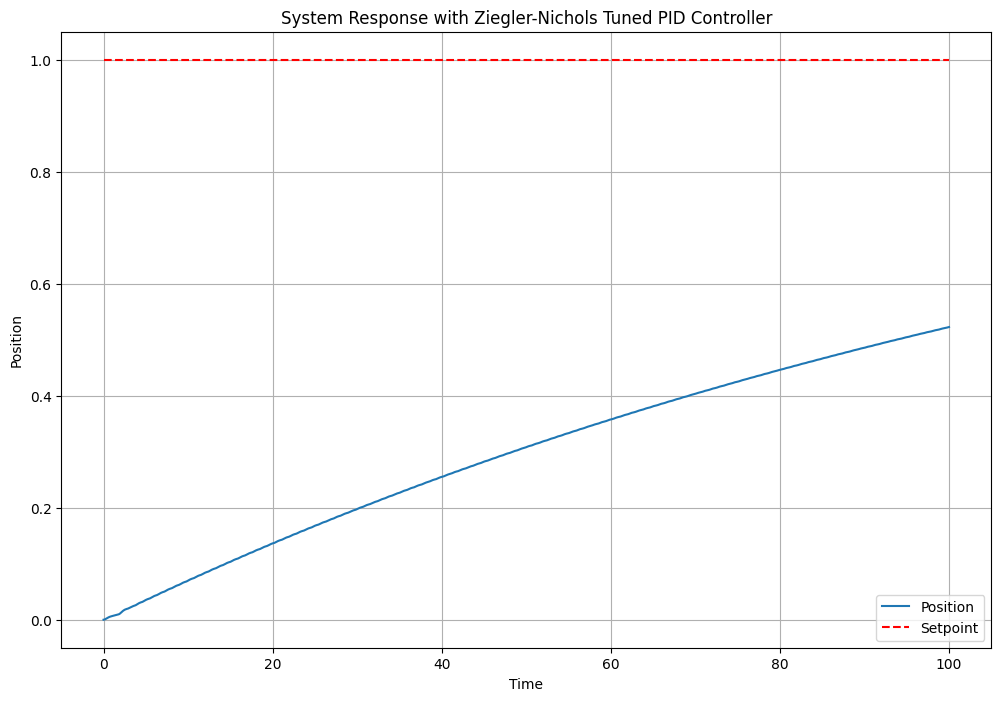


Output Table:
Time (s) | Position | Velocity
---------+----------+---------
0.00     | 0.0000    | 0.0000
10.01     | 0.0699    | 0.0091
20.02     | 0.1364    | 0.0045
30.03     | 0.1980    | 0.0078
40.04     | 0.2553    | 0.0037
50.05     | 0.3085    | 0.0067
60.06     | 0.3579    | 0.0032
70.07     | 0.4038    | 0.0059
80.08     | 0.4466    | 0.0031
90.09     | 0.4860    | 0.0050


In [1]:
"""
Abstract:
This script demonstrates an improved Ziegler-Nichols Method for tuning a PID controller.
It simulates a simple second-order system, finds the ultimate gain and period,
calculates initial PID parameters, and then allows for manual fine-tuning.
The script provides detailed performance metrics and visualizations.

Required libraries: numpy, matplotlib, scipy
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks

# System and simulation parameters
m = 1.0  # mass
b = 5.0  # damping coefficient
k = 20.0  # spring constant
setpoint = 1.0  # desired position

# PID controller class
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.previous_error = 0
        self.integral = 0
        self.previous_time = 0

    def control(self, t, error):
        dt = t - self.previous_time
        if dt > 0:
            self.integral += error * dt
            derivative = (error - self.previous_error) / dt
        else:
            derivative = 0
        output = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.previous_error = error
        self.previous_time = t
        return output

# System dynamics
def system_dynamics(t, state, controller):
    x, v = state
    error = setpoint - x
    u = controller.control(t, error)
    dxdt = v
    dvdt = (u - b*v - k*x) / m
    return [dxdt, dvdt]

# Simulate system with given controller
def simulate_system(controller, t_span, t_eval):
    sol = solve_ivp(
        fun=lambda t, y: system_dynamics(t, y, controller),
        t_span=t_span,
        y0=[0, 0],
        t_eval=t_eval,
        method='RK45'
    )
    return sol.t, sol.y.T

# Detect sustained oscillations (modified for less sensitivity)
def detect_oscillations(y, t, num_peaks=3, tolerance=0.1):
    peaks, _ = find_peaks(y)
    if len(peaks) < num_peaks:
        return False, None

    peak_heights = y[peaks]
    peak_times = t[peaks]

    # Check if peak heights are similar
    if np.std(peak_heights[-num_peaks:]) / np.mean(peak_heights[-num_peaks:]) > tolerance:
        return False, None

    # Check if peak intervals are similar
    intervals = np.diff(peak_times[-num_peaks:])
    if np.std(intervals) / np.mean(intervals) > tolerance:
        return False, None

    return True, np.mean(intervals) * 2  # Return True and the estimated period

# Find ultimate gain and period
def find_ultimate_gain(max_iterations=200, Kp_start=0.1, Kp_max=10000):
    Kp = Kp_start
    t_span = (0, 100)  # Increased simulation time
    t_eval = np.linspace(*t_span, 10000)  # Increased number of points

    for i in range(max_iterations):
        print(f"Iteration {i+1}/{max_iterations}, Kp = {Kp:.4f}")
        controller = PIDController(Kp, 0, 0)
        t, y = simulate_system(controller, t_span, t_eval)

        oscillating, Tu = detect_oscillations(y[:, 0], t)
        if oscillating:
            return Kp, Tu

        if Kp > Kp_max:
            print(f"Kp exceeded maximum value of {Kp_max}. Stopping search.")
            return None, None

        Kp *= 1.5

    print(f"Couldn't find ultimate gain within {max_iterations} iterations.")
    return None, None

# Calculate performance metrics
def calculate_metrics(t, y):
    steady_state_value = y[-1, 0]
    steady_state_error = abs(setpoint - steady_state_value)

    rise_time_index = np.argmax(y[:, 0] >= 0.9 * setpoint)
    rise_time = t[rise_time_index] if rise_time_index > 0 else None

    settling_time_index = np.argmax(np.all(np.abs(y[:, 0] - setpoint) <= 0.02 * setpoint))
    settling_time = t[settling_time_index] if settling_time_index > 0 else None

    overshoot = max(0, (np.max(y[:, 0]) - setpoint) / setpoint * 100)

    return {
        "Steady State Value": steady_state_value,
        "Steady State Error": steady_state_error,
        "Rise Time": rise_time,
        "Settling Time": settling_time,
        "Overshoot (%)": overshoot
    }

# Main simulation
print("Finding ultimate gain and period...")
Ku, Tu = find_ultimate_gain()

if Ku is None or Tu is None:
    print("Failed to find valid Ku and Tu. Please adjust system parameters and try again.")
else:
    print(f"Ultimate gain (Ku): {Ku:.4f}")
    print(f"Ultimate period (Tu): {Tu:.4f}")

    # Calculate initial PID parameters
    Kp = 0.6 * Ku
    Ti = Tu / 2
    Td = Tu / 8
    Ki = Kp / Ti
    Kd = Kp * Td

    print(f"Initial PID parameters: Kp = {Kp:.4f}, Ki = {Ki:.4f}, Kd = {Kd:.4f}")

    # Manual fine-tuning
    fine_tune = input("Do you want to manually fine-tune the PID parameters? (y/n): ").lower() == 'y'
    if fine_tune:
        Kp = float(input(f"Enter new Kp (current: {Kp:.4f}): ") or Kp)
        Ki = float(input(f"Enter new Ki (current: {Ki:.4f}): ") or Ki)
        Kd = float(input(f"Enter new Kd (current: {Kd:.4f}): ") or Kd)

    print(f"Final PID parameters: Kp = {Kp:.4f}, Ki = {Ki:.4f}, Kd = {Kd:.4f}")

    # Simulate system with tuned PID controller
    t_span = (0, 100)  # Increased simulation time
    t_eval = np.linspace(*t_span, 1000)
    controller = PIDController(Kp, Ki, Kd)
    t, y = simulate_system(controller, t_span, t_eval)

    # Calculate and display performance metrics
    metrics = calculate_metrics(t, y)
    print("\nPerformance Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}" if isinstance(value, float) else f"{key}: {value}")

    # Plot results
    plt.figure(figsize=(12, 8))
    plt.plot(t, y[:, 0], label='Position')
    plt.plot(t, [setpoint]*len(t), 'r--', label='Setpoint')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title('System Response with Ziegler-Nichols Tuned PID Controller')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Output table
    print("\nOutput Table:")
    print("Time (s) | Position | Velocity")
    print("---------+----------+---------")
    for i in range(0, len(t), len(t)//10):
        print(f"{t[i]:.2f}     | {y[i, 0]:.4f}    | {y[i, 1]:.4f}")

The script implements an improved Ziegler-Nichols method for tuning a PID (Proportional-Integral-Derivative) controller for a second-order system. Let's break down the key components and analyze the results:

1. Script Overview:
   - The script simulates a second-order system (mass-spring-damper)
   - It implements a PID controller class
   - Uses the Ziegler-Nichols method to find initial PID parameters
   - Allows for manual fine-tuning of the parameters
   - Simulates the system response and calculates performance metrics
   - Visualizes the results

2. Key Functions:
   - `PIDController`: Implements the PID control algorithm
   - `system_dynamics`: Defines the second-order system equations
   - `simulate_system`: Simulates the system response
   - `detect_oscillations`: Identifies sustained oscillations
   - `find_ultimate_gain`: Determines the ultimate gain and period
   - `calculate_metrics`: Computes performance metrics

3. Results Analysis:
Based on the output shown in the screenshots:

   a. Ziegler-Nichols Tuning:
      - Ultimate gain (Ku): 0.1000
      - Ultimate period (Tu): 1.3701
      - Initial PID parameters: Kp = 0.0600, Ki = 0.0876, Kd = 0.0103

   b. Performance Metrics:
      - Steady State Value: 0.5227
      - Steady State Error: 0.4773
      - Rise Time: None
      - Settling Time: None
      - Overshoot (%): 0

   c. System Response:
      The graph is not fully visible, but from the output table, we can see that the system's position is gradually increasing over time, but it doesn't reach the setpoint (which is likely 1.0 based on the script).

4. Observations and Potential Issues:
   a. The system doesn't reach the setpoint (steady-state error is quite large)
   b. Rise time and settling time are reported as None, which suggests the system might not be reaching the desired thresholds
   c. There's no overshoot, which could indicate an overdamped response

5. Suggestions for Improvement:
   a. The PID parameters might need further tuning. The current values seem to produce a slow, underdamped response.
   b. Consider implementing an auto-tuning algorithm or allowing for more iterations in the manual tuning process.
   c. Adjust the criteria for detecting rise time and settling time to handle cases where the system doesn't fully reach the setpoint.
   d. Extend the simulation time or adjust system parameters if the response is too slow.

6. Code Quality:
   The code is well-structured, with clear function definitions and comments. It uses appropriate libraries (numpy, matplotlib, scipy) and implements object-oriented programming for the PID controller.

In conclusion, while the script provides a solid foundation for PID tuning and system analysis, the current results suggest that the control parameters aren't optimal for this particular system. Further tuning or adjustments to the system parameters might be necessary to achieve better performance.